In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import os
import GPUtil
GPUtil.showUtilization()
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import time

| ID | GPU | MEM |
------------------


In [2]:
class SIGNSDataset(Dataset):
    """
    A standard PyTorch definition of Dataset which defines the functions __len__ and __getitem__.
    """
    def __init__(self, data_dir, transform):
        """
        Store the filenames of the jpgs to use. Specifies transforms to apply on images.
        Args:
            data_dir: (string) directory containing the dataset
            transform: (torchvision.transforms) transformation to apply on image
        """
        self.filenames = os.listdir(data_dir)
        self.filenames = [os.path.join(data_dir, f) for f in self.filenames if f.endswith('.jpg')]

        self.labels = [int(os.path.split(filename)[-1][0]) for filename in self.filenames]
        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.filenames)

    def __getitem__(self, idx):
        """
        Fetch index idx image and labels from dataset. Perform transforms on image.
        Args:
            idx: (int) index in [0, 1, ..., size_of_dataset-1]
        Returns:
            image: (Tensor) transformed image
            label: (int) corresponding label of image
        """
        image = Image.open(self.filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [3]:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
    transforms.ToTensor()])  # transform it into a torch tensor

train_data_path = "dataset/train_signs/"
traindata = SIGNSDataset(train_data_path, train_transformer)

dl = DataLoader(traindata, batch_size=32, shuffle=True,
                                        num_workers=4,
                                        pin_memory=True)

In [4]:
test_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
    transforms.ToTensor()])  # transform it into a torch tensor

test_data_path = "dataset/test_signs/"
testdata = SIGNSDataset(train_data_path, train_transformer)

tl = DataLoader(testdata, batch_size=32, shuffle=False,
                                        num_workers=4,
                                        pin_memory=True)

In [5]:
a,b = dl.dataset[0]
print(a.shape)

torch.Size([3, 64, 64])


In [6]:
class Net(nn.Module):
    """
    This is the standard way to define your own network in PyTorch. You typically choose the components
    (e.g. LSTMs, linear layers etc.) of your network in the __init__ function. You then apply these layers
    on the input step-by-step in the forward function. You can use torch.nn.functional to apply functions
    such as F.relu, F.sigmoid, F.softmax, F.max_pool2d. Be careful to ensure your dimensions are correct after each
    step. You are encouraged to have a look at the network in pytorch/nlp/model/net.py to get a better sense of how
    you can go about defining your own network.
    The documentation for all the various components available o you is here: http://pytorch.org/docs/master/nn.html
    """

    def __init__(self):

        super(Net, self).__init__()
        self.num_channels = 32
        
        # each of the convolution layers below have the arguments (input_channels, output_channels, filter_size,
        # stride, padding). We also include batch normalisation layers that help stabilise training.
        # For more details on how to use these layers, check out the documentation.
        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.num_channels)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.num_channels*2)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self.num_channels*4)

        # 2 fully connected layers to transform the output of the convolution layers to the final output
        self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
        self.fcbn1 = nn.BatchNorm1d(self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)       
        self.dropout_rate = 0.8

    def forward(self, s):

        #                                                  -> batch_size x 3 x 64 x 64
        # we apply the convolution layers, followed by batch normalisation, maxpool and relu x 3
        s = self.bn1(self.conv1(s))                         # batch_size x num_channels x 64 x 64
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels x 32 x 32
        s = self.bn2(self.conv2(s))                         # batch_size x num_channels*2 x 32 x 32
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*2 x 16 x 16
        s = self.bn3(self.conv3(s))                         # batch_size x num_channels*4 x 16 x 16
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*4 x 8 x 8

        # flatten the output for each image
        s = s.view(-1, 8*8*self.num_channels*4)             # batch_size x 8*8*num_channels*4

        # apply 2 fully connected layers with dropout
        s = F.dropout(F.relu(self.fcbn1(self.fc1(s))), 
            p=self.dropout_rate, training=self.training)    # batch_size x self.num_channels*4
        s = self.fc2(s)                                     # batch_size x 6

        # apply log softmax on each image's output (this is recommended over applying softmax
        # since it is numerically more stable)
        return F.log_softmax(s, dim=1)

In [7]:
if torch.cuda.is_available():
    cnn = Net().cuda()
    print("Run in GPU")
else:
    cnn = Net()
print(cnn)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fcbn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [8]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()  

In [9]:
def train(epoch):
    for i, (train_batch, labels_batch) in enumerate(dl):
        train_batch, labels_batch = train_batch, labels_batch
        # convert to torch Variables
        train_batch, labels_batch = Variable(train_batch), Variable(labels_batch)

        # compute model output and loss
        output_batch = cnn(train_batch)
        loss = loss_func(output_batch, labels_batch)
        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()
        if i % 8 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, 
                    i * len(train_batch), len(dl.dataset),100. * i / len(dl), loss.data.item()))
    print("Finish")
    GPUtil.showUtilization()

In [10]:
def test():
    cnn.eval()
    test_loss = 0
    correct = 0
    for data, target in tl:
        data, target = Variable(data), Variable(target)
        output = cnn(data)
        # sum up batch loss
        los = loss_func(output, target)
        #print(los)
        test_loss += los
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    #print(test_loss)
    test_loss /= len(tl)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, correct, len(tl.dataset),
        100. * correct / len(tl.dataset)))
    
    
    #print(float(test_loss))
    global Loss
    global Accuracy
    #Loss = np.append(Loss,float(test_loss))
    #print(Loss)
    #Accuracy = np.append(Accuracy,float(100. * correct / len(tl.dataset)))

In [11]:
for epoch in range(1,20):
    if epoch == 1:
        ts = time.time()
    train(epoch)
    test()
te = time.time()
print("Total cost %f sec" % (te - ts))

Train Epoch: 1 [0/864 (0%)]	Loss: 1.902371
Train Epoch: 1 [256/864 (30%)]	Loss: 1.487707
Train Epoch: 1 [512/864 (59%)]	Loss: 1.558318
Train Epoch: 1 [768/864 (89%)]	Loss: 1.292510
Finish
| ID | GPU | MEM |
------------------

Test set: Average loss: 2.0985, Accuracy: 160/864 (18%)

Train Epoch: 2 [0/864 (0%)]	Loss: 1.998375
Train Epoch: 2 [256/864 (30%)]	Loss: 1.610687
Train Epoch: 2 [512/864 (59%)]	Loss: 1.420069
Train Epoch: 2 [768/864 (89%)]	Loss: 1.545844
Finish
| ID | GPU | MEM |
------------------

Test set: Average loss: 1.1183, Accuracy: 469/864 (54%)

Train Epoch: 3 [0/864 (0%)]	Loss: 1.084097
Train Epoch: 3 [256/864 (30%)]	Loss: 0.995580
Train Epoch: 3 [512/864 (59%)]	Loss: 0.798327
Train Epoch: 3 [768/864 (89%)]	Loss: 0.643231
Finish
| ID | GPU | MEM |
------------------

Test set: Average loss: 0.6215, Accuracy: 687/864 (79%)

Train Epoch: 4 [0/864 (0%)]	Loss: 0.559471
Train Epoch: 4 [256/864 (30%)]	Loss: 0.448374
Train Epoch: 4 [512/864 (59%)]	Loss: 0.757775
Train Epoch: 

In [12]:
torch.save(cnn, 'cnn_stanford2.pkl')

/Users/tonyguo/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [22]:
#single image test
import matplotlib.pyplot as plt
single_transforms = transforms.Compose(
        [
        transforms.Resize((64,64)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
        ]
)
model  = torch.load('cnn_stanford2.pkl').cpu()

torch.Size([3, 64, 64])
torch.Size([1, 3, 64, 64])
(3, 64, 64)
(64, 64, 3)


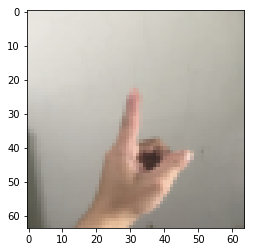

In [23]:
img = Image.open("image.jpg")
image = single_transforms(img).cpu()
imgToShow = image.numpy()
print(image.shape)
image = image.unsqueeze(0)
print(image.shape)

print(imgToShow.shape)
imgToShow = imgToShow.transpose((1, 2, 0))
print(imgToShow.shape)
plt.imshow(imgToShow, cmap='gray')
plt.show()

In [24]:
single_out = model(image)
#print(single_out)
p = torch.max(single_out, 1)[1].data.numpy().squeeze()
print(p)

1


In [26]:
#onnx to caffe2 
batch_size=1  # 随便一个数
x = Variable(torch.randn(batch_size,3,64,64), requires_grad=True).cuda()
torch_out = torch.onnx._export(cnn, x, "onnx/cnn_stanford.onnx", export_params=True )

In [27]:
import onnx

# Load the ONNX model
model = onnx.load("onnx/cnn_stanford.onnx")
# Check that the IR is well formed
onnx.checker.check_model(model)
# Print a human readable representation of the graph
onnx.helper.printable_graph(model.graph)

'graph torch-jit-export (\n  %0[FLOAT, 1x3x64x64]\n) initializers (\n  %1[FLOAT, 32x3x3x3]\n  %2[FLOAT, 32]\n  %3[FLOAT, 32]\n  %4[FLOAT, 32]\n  %5[FLOAT, 32]\n  %6[FLOAT, 32]\n  %7[INT64, scalar]\n  %8[FLOAT, 64x32x3x3]\n  %9[FLOAT, 64]\n  %10[FLOAT, 64]\n  %11[FLOAT, 64]\n  %12[FLOAT, 64]\n  %13[FLOAT, 64]\n  %14[INT64, scalar]\n  %15[FLOAT, 128x64x3x3]\n  %16[FLOAT, 128]\n  %17[FLOAT, 128]\n  %18[FLOAT, 128]\n  %19[FLOAT, 128]\n  %20[FLOAT, 128]\n  %21[INT64, scalar]\n  %22[FLOAT, 128x8192]\n  %23[FLOAT, 128]\n  %24[FLOAT, 128]\n  %25[FLOAT, 128]\n  %26[FLOAT, 128]\n  %27[FLOAT, 128]\n  %28[INT64, scalar]\n  %29[FLOAT, 6x128]\n  %30[FLOAT, 6]\n) {\n  %31 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [1, 1, 1, 1], strides = [1, 1]](%0, %1, %2)\n  %32 = BatchNormalization[epsilon = 9.99999974737875e-06, momentum = 1](%31, %3, %4, %5, %6)\n  %33 = MaxPool[kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]](%32)\n  %34 = Relu(%33)\n  %35 = Conv[dilations 

In [34]:
# ...continuing from above
import caffe2.python.onnx.backend as backend
import numpy as np

rep = backend.prepare(model, device="CUDA:0") # or "CPU"
# For the Caffe2 backend:
#     rep.predict_net is the Caffe2 protobuf for the network
#     rep.workspace is the Caffe2 workspace for the network
#       (see the class caffe2.python.onnx.backend.Workspace)
outputs = rep.run(np.random.randn(10, 3, 64, 64).astype(np.float32))
# To run networks with more than one input, pass a tuple
# rather than a single numpy ndarray.

from caffe2.python.onnx.backend import Caffe2Backend as c2
init_net, predict_net = c2.onnx_graph_to_caffe2_net(model)
with open("onnx/init_net.pb", "wb") as f:
    f.write(init_net.SerializeToString())
with open("onnx/predict_net.pb", "wb") as f:
    f.write(predict_net.SerializeToString())

CUDA operators do not support 64-bit doubles, please use arr.astype(np.float32) or np.int32 for ints. Blob: 0 type: float64
